In [22]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
import joblib

from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

In [23]:
# Load the dataset
data = pd.read_csv('/Users/suchithkurra/Desktop/Honey_Pot Research/data/Web_attack.csv')

In [24]:
# Data preprocessing
# Drop any rows with missing values
data.dropna(inplace=True)

In [25]:
# Replace infinite or very large values with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [26]:
# Drop rows containing NaN values
data.dropna(inplace=True)

In [27]:
from sklearn.preprocessing import LabelEncoder

# Encode target variable
label_encoder = LabelEncoder()
data['Label'] = label_encoder.fit_transform(data['Label'])

In [28]:
# Split features and target variable
X = data.drop('Label', axis=1)
y = data['Label']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
# SelectKBest with ANOVA F-value
k = 20  # Number of top features to select
selector = SelectKBest(score_func=f_classif, k=k)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

In [32]:
selected_features_indices = selector.get_support(indices=True)

In [33]:
selected_feature_names = X.columns[selected_features_indices]

In [34]:
# Print the selected feature names
print("Selected features:")
print(selected_feature_names)

Selected features:
Index(['Destination Port', 'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Fwd IAT Std', 'Min Packet Length',
       'Max Packet Length', 'Packet Length Mean', 'Packet Length Std',
       'PSH Flag Count', 'ACK Flag Count', 'Down/Up Ratio',
       'Average Packet Size', ' Avg Fwd Segment Size', 'Avg Bwd Segment Size',
       'Init_Win_bytes_forward', 'Init_Win_bytes_backward',
       'min_seg_size_forward'],
      dtype='object')


In [35]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_selected, y_train)

RandomForestClassifier(random_state=42)

In [36]:
# Predictions
y_pred = rf_model.predict(X_test_selected)

In [37]:
# Evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     33590
           1       0.84      0.85      0.84       322

    accuracy                           1.00     33912
   macro avg       0.92      0.92      0.92     33912
weighted avg       1.00      1.00      1.00     33912

Confusion Matrix:
[[33538    52]
 [   49   273]]


In [43]:
# Predict probabilities on the test set
y_score = rf_model.predict_proba(X_test_selected)

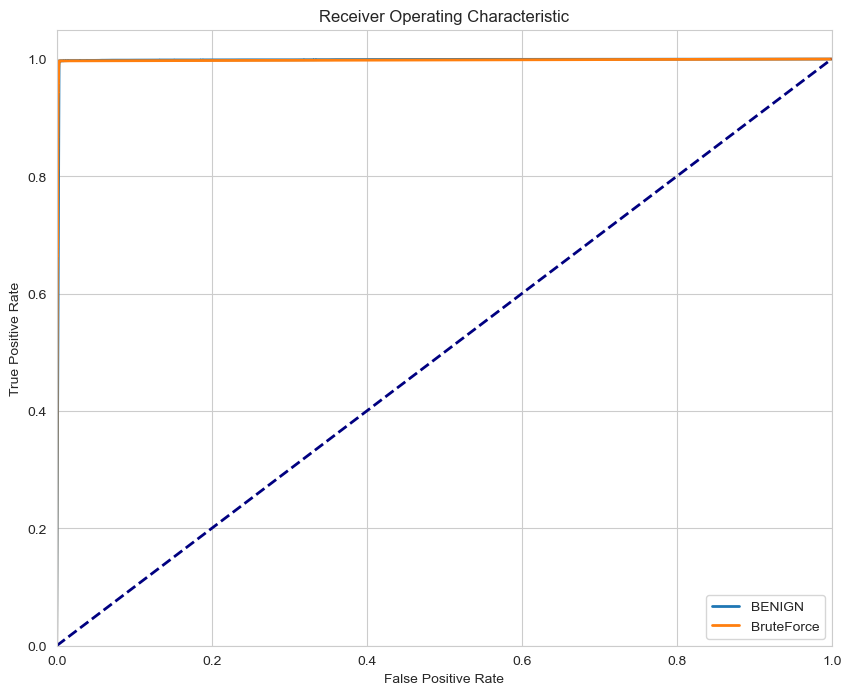

In [44]:
labels = label_encoder.classes_
# Define class names
class_names = label_encoder.classes_
# Compute ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(rf_model.classes_)):
    fpr, tpr, _ = roc_curve(y_test == rf_model.classes_[i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=class_names[i])

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [45]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')


In [46]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

Accuracy: 0.9970217032318943
Precision: 0.9970357284532506
F1 Score: 0.997028541590426
ROC AUC Score: 0.9975887067098868


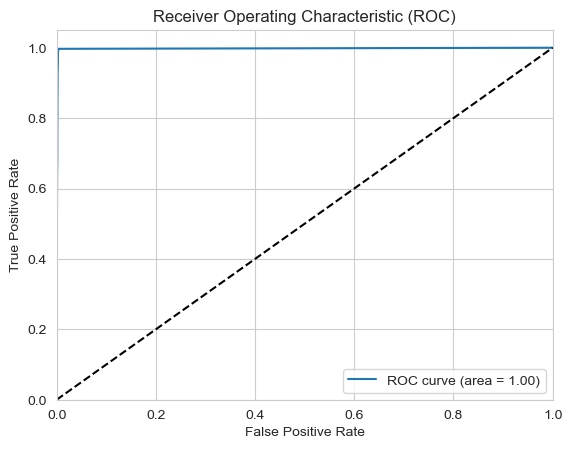

In [47]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, rf_model.predict_proba(X_test_selected)[:,1], pos_label=1)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

Confusion Matrix:
[[33538    52]
 [   49   273]]


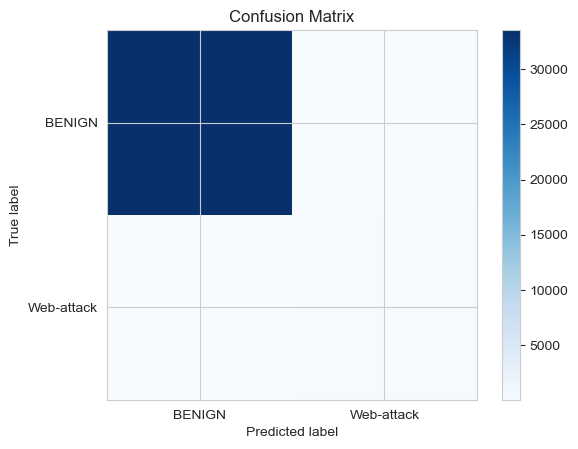

In [48]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks([0, 1], ['BENIGN', 'Web-attack'])
plt.yticks([0, 1], ['BENIGN', 'Web-attack'])
plt.show()

In [49]:
# Extracting false positives and false negatives from confusion matrix
FP = conf_matrix[0, 1]  # False positives: predicted DDoS, actual BENIGN
FN = conf_matrix[1, 0]  # False negatives: predicted BENIGN, actual DDoS

print("False Positives:", FP)
print("False Negatives:", FN)

False Positives: 52
False Negatives: 49


In [50]:
# Number of test values
num_test_values = len(y_test)
print("Number of test values:", num_test_values)

Number of test values: 33912


In [51]:
# Calculate percentage of false positives and false negatives
percentage = ((FP + FN) / num_test_values) * 100

print("Percentage of False Positives and False Negatives: {:.2f}%".format(percentage))

Percentage of False Positives and False Negatives: 0.30%


In [52]:
import joblib

# Save the trained model to a file
joblib.dump(rf_model, 'web_attack_rfmodel.pkl')


['web_attack_rfmodel.pkl']

[[33538    52]
 [   49   273]]


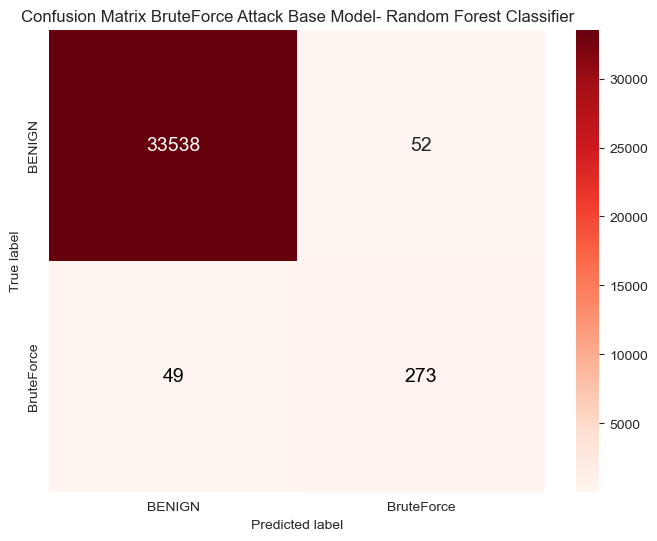

In [62]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
import joblib

from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

labels = label_encoder.classes_
# Define class names
plt.show()
print(conf_matrix)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', annot_kws={"size": 14},
            xticklabels=labels, yticklabels=labels)

# Manually annotate specific cells
plt.text(1.5, 1.5, '273', fontsize=14, color='black', ha='center', va='center')
plt.text(0.5, 1.5, '49', fontsize=14, color='black', ha='center', va='center')
# plt.text(0.5, 2.5, '645', fontsize=14, color='black', ha='center', va='center')
# plt.text(1.5, 2.5, '4', fontsize=14, color='black', ha='center', va='center')
# plt.text(2.5, 1.5, '0', fontsize=14, color='black', ha='center', va='center')
# plt.text(2.5, 2.5, '583', fontsize=14, color='black', ha='center', va='center')

plt.title('Confusion Matrix BruteForce Attack Base Model- Random Forest Classifier')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()